In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [12]:
VERSION  = "NB_EXP_010"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(size, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing(p=0.75))
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

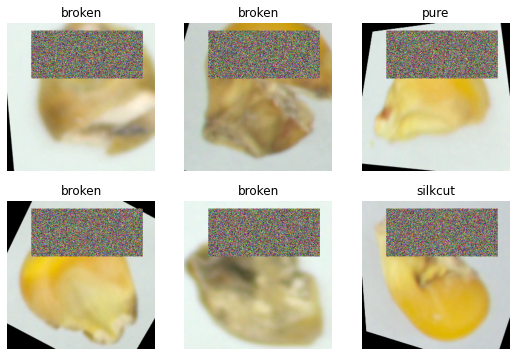

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [10]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
#     dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                            loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
#                            splitter=partial(timm_split, cut=-3)).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [13]:
n_epo = 10; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_010_convnext_tiny_256_bs32_epo10_augsV2_mixup_ft


In [14]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            #wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None),
                   MixUp(alpha=0.2)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.267303,0.838512,0.656545,00:33


Better model found at epoch 0 with accuracy value: 0.6565445065498352.


epoch,train_loss,valid_loss,accuracy,time
0,0.953710,0.666034,0.737173,00:44
1,0.869425,0.656618,0.746597,00:44
2,0.835776,0.641436,0.754974,00:44
3,0.812298,0.867676,0.671204,00:44
4,0.747791,0.552373,0.779756,00:44
5,0.726865,0.528266,0.793717,00:44
6,0.694400,0.506371,0.792321,00:44
7,0.657062,0.501396,0.803141,00:44
8,0.643784,0.490371,0.802792,00:44
9,0.629202,0.483618,0.804538,00:44


Better model found at epoch 0 with accuracy value: 0.7371727824211121.
Better model found at epoch 1 with accuracy value: 0.7465968728065491.
Better model found at epoch 2 with accuracy value: 0.754973828792572.
Better model found at epoch 4 with accuracy value: 0.7797556519508362.
Better model found at epoch 5 with accuracy value: 0.7937172651290894.
Better model found at epoch 7 with accuracy value: 0.8031413555145264.
Better model found at epoch 9 with accuracy value: 0.8045375347137451.
CPU: 817/47/3717 MB | GPU: 760/2424/6899 MB | Time 0:08:18.015 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.244433,0.848558,0.664223,00:33


Better model found at epoch 0 with accuracy value: 0.6642233729362488.


epoch,train_loss,valid_loss,accuracy,time
0,0.960151,0.667703,0.735777,00:44
1,0.848608,0.645983,0.736824,00:44
2,0.846815,0.567199,0.774520,00:44
3,0.784584,0.639114,0.754974,00:44
4,0.757847,0.544069,0.781501,00:44
5,0.718491,0.529790,0.786736,00:44
6,0.720630,0.485154,0.803141,00:44
7,0.667640,0.478448,0.806632,00:44
8,0.657868,0.473063,0.809773,00:44
9,0.661733,0.472205,0.808726,00:44


Better model found at epoch 0 with accuracy value: 0.7357766032218933.
Better model found at epoch 1 with accuracy value: 0.7368237376213074.
Better model found at epoch 2 with accuracy value: 0.7745200991630554.
Better model found at epoch 4 with accuracy value: 0.7815008759498596.
Better model found at epoch 5 with accuracy value: 0.7867364883422852.
Better model found at epoch 6 with accuracy value: 0.8031413555145264.
Better model found at epoch 7 with accuracy value: 0.8066317439079285.
Better model found at epoch 8 with accuracy value: 0.8097731471061707.
CPU: 166/47/3883 MB | GPU: 172/2700/7071 MB | Time 0:08:15.947 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.242552,0.891835,0.654679,00:33


Better model found at epoch 0 with accuracy value: 0.6546787619590759.


epoch,train_loss,valid_loss,accuracy,time
0,0.926960,0.703198,0.725209,00:44
1,0.862070,0.638606,0.750698,00:44
2,0.797142,0.668277,0.743715,00:44
3,0.772477,0.582322,0.767109,00:44
4,0.745663,0.572796,0.771997,00:44
5,0.728110,0.548924,0.780726,00:44
6,0.698178,0.547972,0.787709,00:44
7,0.694021,0.506739,0.796089,00:44
8,0.640563,0.491477,0.808659,00:44
9,0.645242,0.492971,0.811103,00:44


Better model found at epoch 0 with accuracy value: 0.7252094745635986.
Better model found at epoch 1 with accuracy value: 0.7506983280181885.
Better model found at epoch 3 with accuracy value: 0.7671089172363281.
Better model found at epoch 4 with accuracy value: 0.7719972133636475.
Better model found at epoch 5 with accuracy value: 0.7807262539863586.
Better model found at epoch 6 with accuracy value: 0.7877094745635986.
Better model found at epoch 7 with accuracy value: 0.7960894107818604.
Better model found at epoch 8 with accuracy value: 0.8086591958999634.
Better model found at epoch 9 with accuracy value: 0.811103343963623.
CPU: -1/44/3881 MB | GPU: 94/2634/7165 MB | Time 0:08:17.729 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.233856,0.947369,0.626047,00:34


Better model found at epoch 0 with accuracy value: 0.6260474920272827.


epoch,train_loss,valid_loss,accuracy,time
0,0.926487,0.665868,0.736033,00:44
1,0.877773,0.610263,0.763617,00:44
2,0.839207,0.591446,0.763617,00:44
3,0.789423,0.563768,0.770950,00:44
4,0.749914,0.511926,0.791899,00:44
5,0.742243,0.553475,0.770950,00:44
6,0.716551,0.480177,0.812151,00:44
7,0.697321,0.463582,0.814944,00:44
8,0.639556,0.456379,0.809707,00:44
9,0.648284,0.452983,0.819483,00:44


Better model found at epoch 0 with accuracy value: 0.7360334992408752.
Better model found at epoch 1 with accuracy value: 0.7636173367500305.
Better model found at epoch 3 with accuracy value: 0.7709497213363647.
Better model found at epoch 4 with accuracy value: 0.7918994426727295.
Better model found at epoch 6 with accuracy value: 0.8121508359909058.
Better model found at epoch 7 with accuracy value: 0.8149441480636597.
Better model found at epoch 9 with accuracy value: 0.81948322057724.
CPU: -12/42/3868 MB | GPU: 118/2496/7283 MB | Time 0:08:15.880 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.234920,0.844491,0.672486,00:33


Better model found at epoch 0 with accuracy value: 0.6724860072135925.


epoch,train_loss,valid_loss,accuracy,time
0,0.968765,0.654400,0.741969,00:44
1,0.857671,0.641395,0.738478,00:44
2,0.837701,0.565209,0.770950,00:44
3,0.766080,0.594981,0.773045,00:45
4,0.757390,0.549264,0.777933,00:44
5,0.730753,0.514417,0.789106,00:44
6,0.711321,0.487531,0.805866,00:44
7,0.704045,0.480622,0.809707,00:44
8,0.662644,0.460554,0.814944,00:44
9,0.643799,0.461439,0.811453,00:44


Better model found at epoch 0 with accuracy value: 0.7419692873954773.
Better model found at epoch 2 with accuracy value: 0.7709497213363647.
Better model found at epoch 3 with accuracy value: 0.7730447053909302.
Better model found at epoch 4 with accuracy value: 0.7779329419136047.
Better model found at epoch 5 with accuracy value: 0.7891061305999756.
Better model found at epoch 6 with accuracy value: 0.8058659434318542.
Better model found at epoch 7 with accuracy value: 0.8097066879272461.
Better model found at epoch 8 with accuracy value: 0.8149441480636597.
CPU: -17/49/3851 MB | GPU: 4/2462/7287 MB | Time 0:08:17.817 | (Consumed/Peaked/Used Total)


In [20]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80768, 0.81152, 0.8139, 0.82332, 0.81425]
Avg: 0.81413
Std: 0.00516


### Train for more epochs ...

In [19]:
# dls = get_dls(0, size=SZ, bs=BS, re=RE)

# mixup = MixUp(.2)
# with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
#     learn.epoch,learn.training = 0,True
#     learn.dl = dls.train
#     b = dls.one_batch()
#     learn._split(b)
#     learn('before_train')
#     learn('before_batch')

# _,axs = plt.subplots(3,3, figsize=(9,9))
# dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [23]:
VERSION  = "NB_EXP_010_v2"
EXP_NAME = f"{VERSION}_convnext_tiny"
MODEL_FOLDER = Path(f'/runs/{VERSION}')

n_epo = 15; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_ft"
print(MODEL_FOLDER); MODEL_FOLDER.mkdir(exist_ok=True)
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

/runs/NB_EXP_010_v2
NB_EXP_010_v2_convnext_tiny_256_bs32_epo15_augsV2_mixup_ft


In [24]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            #wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None),
                   MixUp(alpha=0.2)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.267303,0.838512,0.656545,00:34


Better model found at epoch 0 with accuracy value: 0.6565445065498352.


epoch,train_loss,valid_loss,accuracy,time
0,0.949488,0.660447,0.742059,00:44
1,0.870295,0.625910,0.750087,00:44
2,0.830966,0.628306,0.750436,00:44
3,0.835913,0.840975,0.651658,00:44
4,0.771160,0.587569,0.762304,00:44
5,0.756776,0.587341,0.758813,00:44
6,0.735120,0.618683,0.757766,00:44
7,0.706057,0.532008,0.782897,00:44
8,0.680832,0.527522,0.775567,00:44
9,0.659480,0.507257,0.794066,00:44


Better model found at epoch 0 with accuracy value: 0.7420593500137329.
Better model found at epoch 1 with accuracy value: 0.7500872611999512.
Better model found at epoch 2 with accuracy value: 0.7504363059997559.
Better model found at epoch 4 with accuracy value: 0.7623036503791809.
Better model found at epoch 7 with accuracy value: 0.7828970551490784.
Better model found at epoch 9 with accuracy value: 0.794066309928894.
Better model found at epoch 10 with accuracy value: 0.801047146320343.
Better model found at epoch 11 with accuracy value: 0.8013961315155029.
Better model found at epoch 12 with accuracy value: 0.8048865795135498.
Better model found at epoch 13 with accuracy value: 0.8066317439079285.
Better model found at epoch 14 with accuracy value: 0.8083769679069519.
CPU: 13/90/3915 MB | GPU: 376/2332/7153 MB | Time 0:12:04.333 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.244433,0.848558,0.664223,00:34


Better model found at epoch 0 with accuracy value: 0.6642233729362488.


epoch,train_loss,valid_loss,accuracy,time
0,0.964964,0.685384,0.723560,00:44
1,0.856878,0.607068,0.761257,00:44
2,0.848966,0.575841,0.772426,00:44
3,0.786114,0.723521,0.715532,00:44
4,0.777489,0.565234,0.774171,00:44
5,0.737822,0.552164,0.784293,00:44
6,0.762888,0.547621,0.789878,00:44
7,0.712067,0.514577,0.789878,00:44
8,0.703806,0.504129,0.799302,00:44
9,0.679863,0.525053,0.786038,00:44


Better model found at epoch 0 with accuracy value: 0.7235602140426636.
Better model found at epoch 1 with accuracy value: 0.7612565159797668.
Better model found at epoch 2 with accuracy value: 0.7724258303642273.
Better model found at epoch 4 with accuracy value: 0.7741710543632507.
Better model found at epoch 5 with accuracy value: 0.7842931747436523.
Better model found at epoch 6 with accuracy value: 0.7898778319358826.
Better model found at epoch 8 with accuracy value: 0.7993019223213196.
Better model found at epoch 10 with accuracy value: 0.809424102306366.
Better model found at epoch 11 with accuracy value: 0.8122164011001587.
Better model found at epoch 13 with accuracy value: 0.8125654458999634.
CPU: -13/76/3901 MB | GPU: 162/2422/7315 MB | Time 0:12:05.480 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.242552,0.891835,0.654679,00:34


Better model found at epoch 0 with accuracy value: 0.6546787619590759.


epoch,train_loss,valid_loss,accuracy,time
0,0.931447,0.692378,0.721020,00:44
1,0.875240,0.663224,0.739874,00:44
2,0.804765,0.698922,0.730796,00:45
3,0.780498,0.600727,0.759777,00:45
4,0.772471,0.599470,0.759078,00:44
5,0.752745,0.599183,0.767458,00:44
6,0.733583,0.621742,0.752444,00:45
7,0.736939,0.552181,0.779330,00:44
8,0.685676,0.516562,0.800279,00:44
9,0.657010,0.525792,0.799930,00:44


Better model found at epoch 0 with accuracy value: 0.7210195660591125.
Better model found at epoch 1 with accuracy value: 0.7398743033409119.
Better model found at epoch 3 with accuracy value: 0.7597765326499939.
Better model found at epoch 5 with accuracy value: 0.7674580812454224.
Better model found at epoch 7 with accuracy value: 0.7793295979499817.
Better model found at epoch 8 with accuracy value: 0.8002793192863464.
Better model found at epoch 11 with accuracy value: 0.8016759753227234.
Better model found at epoch 12 with accuracy value: 0.8152933120727539.
CPU: 1/90/3902 MB | GPU: -20/2520/7295 MB | Time 0:12:05.263 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.233856,0.947369,0.626047,00:34


Better model found at epoch 0 with accuracy value: 0.6260474920272827.


epoch,train_loss,valid_loss,accuracy,time
0,0.923080,0.677236,0.718925,00:44
1,0.878878,0.592952,0.769553,00:44
2,0.833487,0.605354,0.759427,00:44
3,0.810333,0.530673,0.794344,00:44
4,0.757907,0.575892,0.769553,00:44
5,0.769442,0.581135,0.763268,00:44
6,0.760842,0.496163,0.807263,00:44
7,0.738495,0.491047,0.805168,00:44
8,0.678287,0.477017,0.812151,00:45
9,0.680351,0.474511,0.806913,00:45


Better model found at epoch 0 with accuracy value: 0.7189245820045471.
Better model found at epoch 1 with accuracy value: 0.7695530652999878.
Better model found at epoch 3 with accuracy value: 0.7943435907363892.
Better model found at epoch 6 with accuracy value: 0.8072625994682312.
Better model found at epoch 8 with accuracy value: 0.8121508359909058.
Better model found at epoch 11 with accuracy value: 0.8205307126045227.
CPU: 1/88/3904 MB | GPU: 10/2502/7305 MB | Time 0:12:05.575 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.234920,0.844491,0.672486,00:34


Better model found at epoch 0 with accuracy value: 0.6724860072135925.


epoch,train_loss,valid_loss,accuracy,time
0,0.981562,0.664164,0.730447,00:44
1,0.879383,0.621319,0.752444,00:44
2,0.847442,0.584426,0.767109,00:44
3,0.781958,0.583602,0.777235,00:45
4,0.778727,0.564728,0.777584,00:44
5,0.766079,0.570658,0.782821,00:44
6,0.738375,0.513074,0.792947,00:44
7,0.740632,0.536148,0.784218,00:45
8,0.701932,0.491097,0.803073,00:44
9,0.676310,0.483916,0.806913,00:44


Better model found at epoch 0 with accuracy value: 0.7304469347000122.
Better model found at epoch 1 with accuracy value: 0.7524441480636597.
Better model found at epoch 2 with accuracy value: 0.7671089172363281.
Better model found at epoch 3 with accuracy value: 0.7772346138954163.
Better model found at epoch 4 with accuracy value: 0.7775837779045105.
Better model found at epoch 5 with accuracy value: 0.7828212380409241.
Better model found at epoch 6 with accuracy value: 0.7929469347000122.
Better model found at epoch 8 with accuracy value: 0.8030726313591003.
Better model found at epoch 9 with accuracy value: 0.806913435459137.
Better model found at epoch 10 with accuracy value: 0.8128491640090942.
Better model found at epoch 11 with accuracy value: 0.8131983280181885.
Better model found at epoch 13 with accuracy value: 0.81948322057724.
CPU: -24/43/3880 MB | GPU: 76/2438/7381 MB | Time 0:12:06.400 | (Consumed/Peaked/Used Total)


In [25]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80942, 0.81257, 0.81599, 0.82053, 0.81599]
Avg: 0.81490
Std: 0.00373
